In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, Binarizer, MinMaxScaler
from sklearn.linear_model import LogisticRegression

from mlxtend.frequent_patterns import apriori, association_rules

In [23]:
## load in data set
df = pd.read_csv('data_for_exam.csv')
df['items'] = df['items'].str.replace("'","")

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   items                 30 non-null     object
 1   purchase_cost         30 non-null     int64 
 2   month_to_date_spend   30 non-null     int64 
 3   items_returned        30 non-null     bool  
 4   credit_card_eligible  30 non-null     object
dtypes: bool(1), int64(2), object(2)
memory usage: 1.1+ KB


Accuracy: 0.3333333333333333
Classification Report: 
              precision    recall  f1-score   support

          no       0.25      0.50      0.33         2
         yes       0.50      0.25      0.33         4

    accuracy                           0.33         6
   macro avg       0.38      0.38      0.33         6
weighted avg       0.42      0.33      0.33         6



Text(0.5, 1.0, 'Confusion Matrix for Credit Card Eligibility')

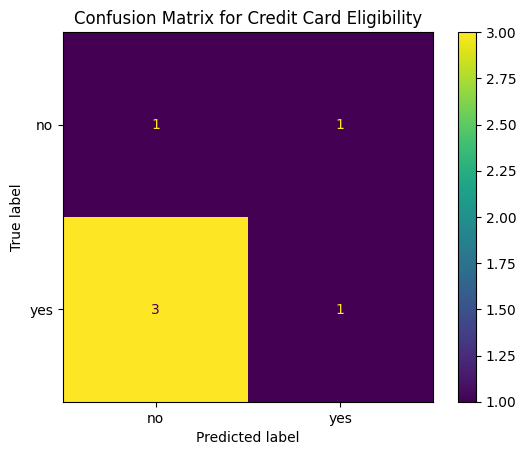

In [28]:
cc_df = df[['purchase_cost', 'month_to_date_spend', 'items_returned', 'credit_card_eligible', ]].copy()
cc_X = cc_df.drop(columns=['credit_card_eligible'])
cc_Y = cc_df['credit_card_eligible']
## preprocess data
numberic_features = ['purchase_cost', 'month_to_date_spend', ]
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])
# cat_features = ['items_returned']
# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numberic_features),
        # ('cat', categorical_transformer, cat_features)
        ])
## apply preprocessing and split data
cc_preprocessed = preprocessor.fit_transform(cc_df)
x_train, x_test, y_train, y_test = train_test_split(cc_X, cc_Y, test_size=0.2, random_state=42)

## train model
model = MultinomialNB()
model.fit(x_train, y_train)
y_preds = model.predict(x_test)

## evaluate model
accuracy = accuracy_score(y_test, y_preds)
report = classification_report(y_test, y_preds)

print(f"Accuracy: {accuracy}")
print(f"Classification Report: \n{report}")

cm = confusion_matrix(y_test, y_preds, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.title("Confusion Matrix for Credit Card Eligibility")
# plt.show()


In [35]:
ad_df = df['items'].copy()
ad_trans = ad_df.str.get_dummies(',')

In [38]:
freq_items = apriori(ad_trans.astype('bool'), min_support=0.1, use_colnames=True)
rules = association_rules(freq_items, metric='confidence', min_threshold=0.2)
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].sort_values(by='lift', ascending=False))

        antecedents      consequents   support  confidence      lift
33     (toothpaste)  ( toilet paper)  0.100000    0.750000  5.625000
32  ( toilet paper)     (toothpaste)  0.100000    0.750000  5.625000
16         ( bread)   (toilet paper)  0.133333    0.500000  3.000000
17   (toilet paper)         ( bread)  0.133333    0.800000  3.000000
10       (computer)          ( book)  0.100000    0.750000  2.812500
11          ( book)       (computer)  0.100000    0.375000  2.812500
31      ( speakers)  (shaving cream)  0.100000    0.333333  2.500000
30  (shaving cream)      ( speakers)  0.100000    0.750000  2.500000
8           ( bike)           (milk)  0.100000    0.300000  2.250000
9            (milk)          ( bike)  0.100000    0.750000  2.250000
22          ( lamp)    ( toothpaste)  0.133333    0.571429  1.558442
23    ( toothpaste)          ( lamp)  0.133333    0.363636  1.558442
28      ( speakers)    ( toothpaste)  0.166667    0.555556  1.515152
29    ( toothpaste)      ( speaker

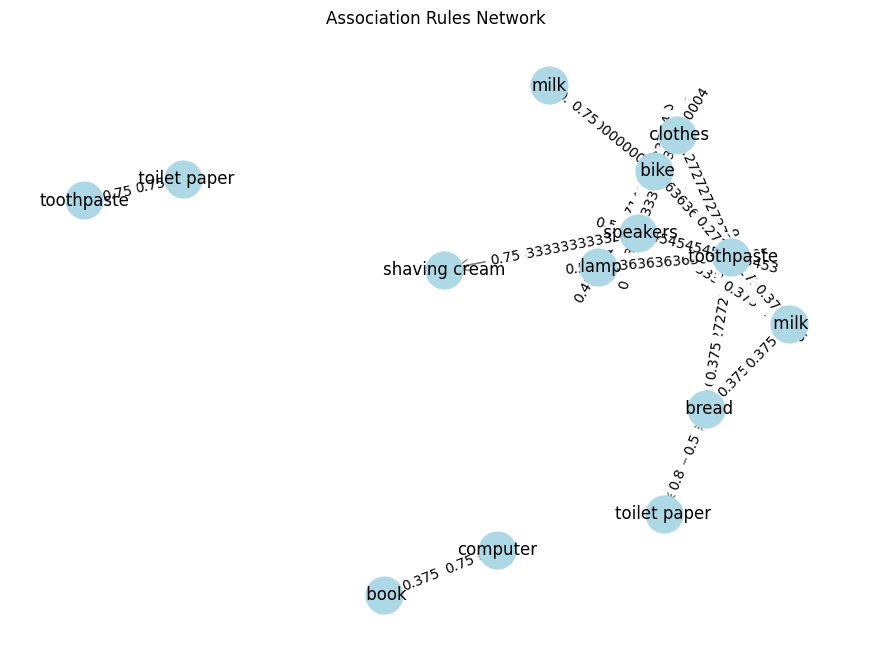

In [40]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

# Add nodes and edges
for _, rule in rules.iterrows():
    for antecedent in rule['antecedents']:
        for consequent in rule['consequents']:
            G.add_edge(antecedent, consequent, weight=rule['confidence'])

# Draw the graph
plt.figure(figsize=(11, 8))

# Adjust the k parameter to increase spacing between nodes
pos = nx.spring_layout(G, seed=42, k=0.5)  # Adjust k value as needed

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue')

# Draw edges
edges = nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=20, edge_color='gray')

# Draw labels
nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

# Add edge labels for confidence
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.3, font_size=10)

# Customize plot
plt.title('Association Rules Network')
plt.axis('off')
# plt.savefig('../images/association_rules.png')
plt.show()